#Loading dataset

In [ ]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf
from collections import Counter
# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

In [ ]:
# misc
import random as rn

# manual parameters
RANDOM_SEED = 42

#Train/test split

In [ ]:
df_ = pd.read_csv("/content/drive/MyDrive/cicids2017 dataset/all_data.csv")

In [ ]:
attack = df_[df_.anomaly == 1]
normal = df_[df_.anomaly == 0]
attack = attack.drop('Label', axis=1)
normal = normal.drop('Label', axis=1)
print(f"""Shape of the datasets:
    clean (rows, cols) = {normal.shape}
    fraud (rows, cols) = {attack.shape}""")

Shape of the datasets:
    clean (rows, cols) = (2271320, 80)
    fraud (rows, cols) = (556556, 80)


In [ ]:
# shuffle our training set
normal = normal.sample(frac=1).reset_index(drop=True)

#TRAINING_SAMPLE= math.ceil(normal.shape[0]*(20/100))
TRAINING_SAMPLE = normal.shape[0] - attack.shape[0]

print(f"""training sample size: {TRAINING_SAMPLE} and normal case size: {normal.shape[0]} left out normals: {normal.shape[0]-TRAINING_SAMPLE}""")

# training set: exlusively normal samples
X_train_all = normal.iloc[:TRAINING_SAMPLE].drop('anomaly', axis=1)

# testing  set: the remaining normal + all the attack samples
X_test = normal.iloc[TRAINING_SAMPLE:].append(attack).sample(frac=1)

print(f"""Our testing set is composed as follows:
{X_test.anomaly.value_counts()}""")
print(f"""Class ratio in testing set is composed as follows:
{X_test.anomaly.value_counts(normalize=True)*100}""")

training sample size: 1714764 and normal case size: 2271320 left out normals: 556556
Our testing set is composed as follows:
1    556556
0    556556
Name: anomaly, dtype: int64
Class ratio in testing set is composed as follows:
1    50.0
0    50.0
Name: anomaly, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
VALIDATE_SIZE = 0.3

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train_all, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

In [ ]:
# manually splitting the labels from the test df
X_test, y_test = X_test.drop('anomaly', axis=1).values, X_test.anomaly.values

In [ ]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (1200334, 79)
    validate (rows, cols) = (514430, 79)
    holdout  (rows, cols) = (1113112, 79)


#Normalising & Standardising

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [ ]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [ ]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

#Training the Variational autoencoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [ ]:
# data dimensions // hyperparameters 
input_dim = X_train.shape[1]

BATCH_SIZE = 8192
EPOCHS = 100

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a point."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation="tanh")(encoder_inputs)
x = layers.Dense(512, activation="tanh")(x)
x = layers.Dense(256,  activation="tanh")(x)


z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 79)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          40960       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="tanh")(latent_inputs)
x = layers.Dense(512, activation="tanh")(x)
x = layers.Dense(512, activation="tanh")(x)
decoder_outputs = layers.Dense(input_dim, activation= "tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 79)                40527     
Total params: 451,407
Trainable params: 451,407
Non-trainable params: 0
_________________________________________________________________


Define VAE as model with a custom train_step

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.built = True

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Train the VAE

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
history = vae.fit(
    X_train_transformed, 
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
);

Epoch 1/100
147/147 [==============================] - 4s 18ms/step - loss: 1558.7266 - reconstruction_loss: 1028.7924 - kl_loss: 37.8914
Epoch 2/100
147/147 [==============================] - 3s 18ms/step - loss: 765.5536 - reconstruction_loss: 727.0952 - kl_loss: 25.1740
Epoch 3/100
147/147 [==============================] - 3s 18ms/step - loss: 730.5480 - reconstruction_loss: 703.4915 - kl_loss: 19.8685
Epoch 4/100
147/147 [==============================] - 3s 18ms/step - loss: 714.7534 - reconstruction_loss: 692.9023 - kl_loss: 16.1024
Epoch 5/100
147/147 [==============================] - 3s 18ms/step - loss: 705.4604 - reconstruction_loss: 687.2036 - kl_loss: 14.1898
Epoch 6/100
147/147 [==============================] - 3s 18ms/step - loss: 700.2109 - reconstruction_loss: 683.5845 - kl_loss: 13.0596
Epoch 7/100
147/147 [==============================] - 3s 18ms/step - loss: 696.4513 - reconstruction_loss: 681.0989 - kl_loss: 12.4960
Epoch 8/100
147/147 [=========================

#Save the model the model weitghts



In [ ]:
vae.save_weights('/content/drive/MyDrive/cicids2017 dataset/vae_tanh,tanh+softmax,adam,512,512,256,64_EPHOCHES_100_b8192.h5')

#Load the model weights
run upto vae compile then :

      first add structure of vae to new_model 
      then add saved model weights into the new_model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
vae.load_weights('/content/drive/MyDrive/cicids2017 dataset/vae_tanh,tanh+softmax,adam,512,512,256,64_EPHOCHES_100_b8192.h5')

In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 64), (None, 64),  467840    
_________________________________________________________________
decoder (Functional)         (None, 79)                451407    
Total params: 919,253
Trainable params: 919,247
Non-trainable params: 6
_________________________________________________________________


#Testing

In [ ]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

In [ ]:
_, _, reconstructed_sample= vae.encoder.predict(X_test_transformed, batch_size=BATCH_SIZE)

In [ ]:
reconstructed_x = vae.decoder.predict(reconstructed_sample,batch_size=BATCH_SIZE)

# MSE and plots

In [ ]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructed_x, 2), axis=1)

In [ ]:
%matplotlib inline

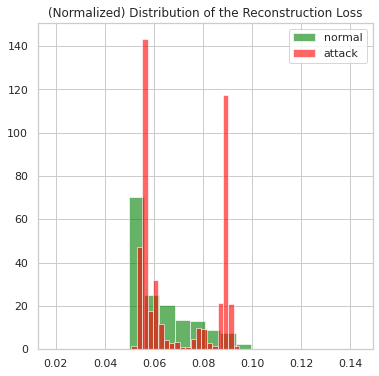

In [ ]:
normal_ = mse[y_test==0]
attack_ = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_, bins=20, density=True, label="normal", alpha=.6, color="green")
ax.hist(attack_, bins=20, density=True, label="attack", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

#Unsupervised
**Percentiles**

We could set this threshold by taking the top x% of the dataset and considering it anomalous.

**MAD**

We could also use a modified Z-score using the Median Absolute Deviation to define outliers on our reconstruction data. This algorithm is more robust and scalable than the percentiles method.

In [ ]:
THRESHOLD = 0.5

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores < THRESHOLD


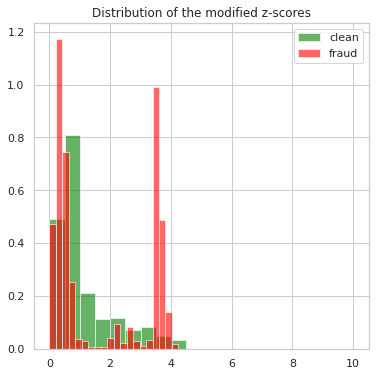

In [ ]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=20, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=20, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [ ]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 367,457 outliers in a total of 1,113,112 transactions [33.01%].


#Supervised
We know the labels, so we can verify our results.



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, outliers))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64    556556
           1       0.63      0.41      0.50    556556

    accuracy                           0.58   1113112
   macro avg       0.60      0.58      0.57   1113112
weighted avg       0.60      0.58      0.57   1113112



#AUC curves

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = mse

if roc_auc_score(y_test, mse_score)<0.5:
    mse_score *= -1

fpr, tpr, thresholds = roc_curve(y_test, mse_score)
auc_score = roc_auc_score(y_test, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

In [ ]:
mse_score = z_scores

if roc_auc_score(y_test, mse_score)<0.5:
    mse_score *= -1

fpr, tpr, thresholds = roc_curve(y_test, mse_score)
auc_score = roc_auc_score(y_test, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();